# Week 2
## Question 2: Linear Regression via Normal Equations


In [156]:
import pandas as pd
import numpy as np

FEATURES = ['Pumps', 'Interior', 'Restaurant', 'CarWash', 'Highway', 'Intersection', 'Stoplight', 'Gasolines',
            'Competitors', 'Income', 'Brand']
df = pd.read_csv('GasPrices.csv')

**'Price'**: The target feature we want to predict.

Dropped Features:
- **'Unnamed: 0'**: ID column, has no value for prediction.
- **'ID'**: ID column, has no value for prediction.
- **'Name'**: Name of the gas station, but doesn't help predict price. In large parts the same as 'Brand'.
- **'IntersectionStoplight'**: Combines info from 'Intersection' and 'Stoplight', so it is redundant.
- **'Zipcode'**: Not useful, we already have other location-based features like 'Highway', 'Intersection', 'Stoplight'.
- **'Address'**: Too specific, does not add any useful information for prediction.


Kept Features:
- **'Pumps'**: Number of pumps, could impact price.
- **'Interior', 'Restaurant', 'CarWash'**: Additional services, might influence price.
- **'Highway', 'Intersection', 'Stoplight'**: Location info, could affect accessibility and pricing.
- **'Gasolines'**: Number of gasoline types offered, could relate to pricing.
- **'Competitors'**: Shows if other stations are nearby, can influence pricing.
- **'Income'**: Average income in the area, likely related to gas prices.
- **'Brand'**: Different brands might price differently.


Now, we split the data with `pandas.DataFrame.sample`. Before that we convert all features to numerical values with the very easy `pandas.get_dummies`, wich is totally sufficient for this task.

In [157]:
X = df[FEATURES]
y = df['Price']

Xdata = pd.get_dummies(X).astype(np.float64)

Xtrain = Xdata.sample(frac=0.8, axis=0, random_state=420)
Xtest = Xdata.drop(Xtrain.index)

Ytrain = y.loc[Xtrain.index]
Ytest = y.loc[Xtest.index]

The following is the model for Linear Regression via Normal equation. The method `LinReg_NormEq.fit` takes one of three algorithms for solving linear equations as an optional argument.

In [158]:
class LinRegNormEq:
    def __init__(self):
        """
        Linear Regression model using the Normal Equation.
        """
        self.B = None

    def fit(self, X, y, algorithm='gauss'):
        """
        Fit the linear regression model to the given data.
        :param X: input feature matrix
        :param y: target values
        :param algorithm: 'gauss', 'cholesky', 'qr' (algorithm to solve the normal equation)
        :return: None
        """
        ALGORITHMS = ['gauss', 'cholesky', 'qr']
        if algorithm not in ALGORITHMS:
            raise ValueError(f'Algorithm must be one of {ALGORITHMS}')

        X = X.to_numpy()
        y = y.to_numpy().reshape(-1, 1)

        X = np.hstack([np.ones((X.shape[0], 1)), X])

        A = X.T @ X
        b = X.T @ y

        # we need to avoid zeros on the main diagonal for gauss and make sure the Matrix is positive definite for cholesky, so we regulate it (add λI do make it more stable)
        A += 1e-8 * np.eye(A.shape[0])

        if algorithm == 'gauss':
            self.B = self._gauss(A, b)
        elif algorithm == 'cholesky':
            self.B = self._cholesky(A, b)
        else:
            self.B = self._qr(A, b)

        # print(f'Shape of B after {algorithm}: {self.B.shape}')  # for debugging reasons

    def predict(self, X):
        """
        Predict using the linear regression model.
        :param X: input feature matrix to predict values for
        :return: predicted values
        """
        if self.B is None:
            raise ValueError("The model has not been trained yet. Please call fit() first.")

        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ self.B

    @staticmethod
    def _gauss(A, b):
        """
        Gaussian Elimination algorithm to solve systems of linear equations.
        The implementation is largely inspired by the YouTube video: https://youtu.be/gAmMxdI0EKs?si=wrCU1qpLQTnXmsHb
        :param A: coefficient matrix
        :param b: constant vector
        :return: solution vector
        """
        n = len(b)
        m = n - 1
        i = 0
        x = np.zeros(n)

        b = b.reshape(-1, 1)

        augmented_matrix = np.concatenate((A, b), axis=1)

        while i < n:
            if augmented_matrix[i][i] == 0.0:
                raise ZeroDivisionError("Zero on main Diagonal")

            for j in range(i + 1, n):
                scaling_factor = augmented_matrix[j][i] / augmented_matrix[i][i]
                augmented_matrix[j] = augmented_matrix[j] - (scaling_factor * augmented_matrix[i])
            i += 1

        x[m] = augmented_matrix[m][n] / augmented_matrix[m][m]

        for k in range(n - 2, -1, -1):
            x[k] = augmented_matrix[k][n]

            for j in range(k + 1, n):
                x[k] = x[k] - augmented_matrix[k][j] * x[j]
            x[k] = x[k] / augmented_matrix[k][k]

        return x.reshape(-1, 1)

    @staticmethod
    def _is_symmetric(matrix, tol=1e-10):
        return np.allclose(matrix, matrix.T, atol=tol)

    @staticmethod
    def _cholesky(A, b):
        """
        Cholesky decomposition algorithm to solve systems of linear equations.
        We can use this, because the matrix A is always symmetric (since it is X.T @ X).
        :param A: coefficient matrix
        :param b: constant vector
        :return: solution vector
        """

        n = A.shape[0]
        L = np.zeros_like(A)

        # inspired from https://github.com/TayssirDo/Cholesky-decomposition, but adjusted to calculate the lower triangular matrix
        for i in range(n):
            L[i, i] = sqrt(A[i, i])
            for j in range(i + 1, n):
                L[j, i] = A[j, i] / L[i, i]
                A[j, j:] = A[j, j:] - L[j, i] * L[i, j:]

        # Solve L * y = b
        y = np.linalg.solve(L, b)

        # Solve L.T * B = y
        B = np.linalg.solve(L.T, y)

        return B

    @staticmethod
    def _qr(A, b):
        """
        QR decomposition algorithm to solve systems of linear equations.
        The implementation is largely inspired by: https://youtu.be/kpk6x2Z6Nfs?si=t5iBnkaD5Pt5qmPQ
        :param A: coefficient matrix
        :param b: constant vector
        :return: solution vector
        """

        m, n = A.shape

        Q = np.zeros((m, n))

        for i, column in enumerate(A.T):
            Q[:, i] = column

            for prev in Q.T[:i]:
                Q[:, i] -= (prev @ column) / (prev @ prev) * prev

        Q /= np.linalg.norm(Q, axis=0)
        R = Q.T @ A

        # Q, R = np.linalg.qr(A)  # for testing

        # Now that we have Q and R, solve R * B = Q.T * b
        y = Q.T @ b
        B = np.linalg.solve(R, y)

        return B

We use this model to perform the predictions, using all three different approaches for solving the normal equation.

In [159]:
model = LinRegNormEq()

model.fit(Xtrain, Ytrain, algorithm='gauss')
Ypred_gauss = model.predict(Xtest).ravel()

model.fit(Xtrain, Ytrain, algorithm='cholesky')
Ypred_cholesky = model.predict(Xtest).ravel()

model.fit(Xtrain, Ytrain, algorithm='qr')
Ypred_qr = model.predict(Xtest).ravel()

Now, we plot each the residual versus the true value of ytest for each approach.

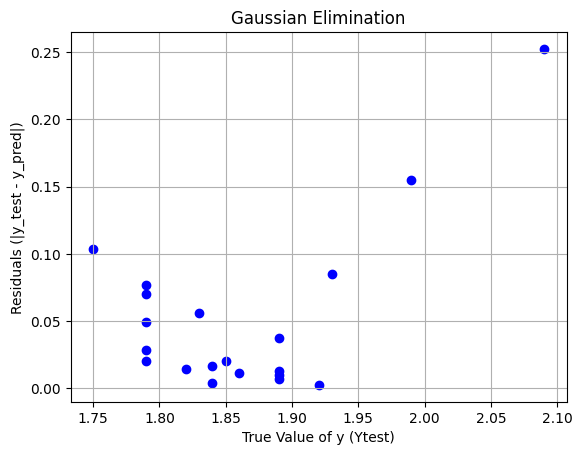

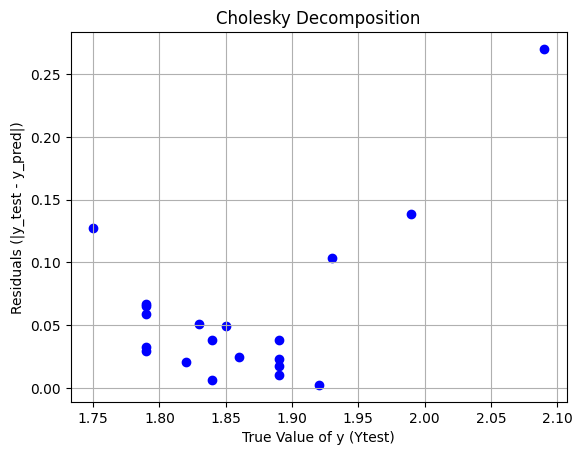

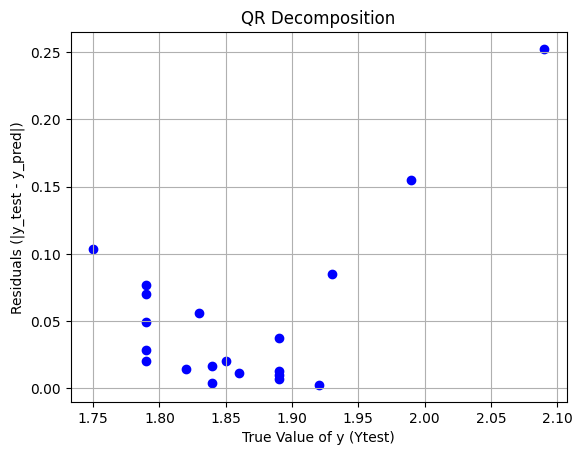

In [160]:
from matplotlib import pyplot as plt

residuals_gauss = np.abs(Ytest.to_numpy() - Ypred_gauss)

plt.scatter(Ytest, residuals_gauss, color='blue')
plt.xlabel('True Value of y (Ytest)')
plt.ylabel('Residuals (|y_test - y_pred|)')
plt.title(f'Gaussian Elimination')
plt.grid(True)
plt.show()
plt.close()

residuals_cholesky = np.abs(Ytest.to_numpy() - Ypred_cholesky)

plt.scatter(Ytest, residuals_cholesky, color='blue')
plt.xlabel('True Value of y (Ytest)')
plt.ylabel('Residuals (|y_test - y_pred|)')
plt.title(f'Cholesky Decomposition')
plt.grid(True)
plt.show()
plt.close()

residuals_qr = np.abs(Ytest.to_numpy() - Ypred_qr)

plt.scatter(Ytest, residuals_qr, color='blue')
plt.xlabel('True Value of y (Ytest)')
plt.ylabel('Residuals (|y_test - y_pred|)')
plt.title(f'QR Decomposition')
plt.grid(True)
plt.show()
plt.close()

We see, that the residuals are very similar for each approach. The scatter looks almost the same. The only noticeable difference is that Cholesky Decomposition seems to perform worse, having slightly higher residual values.

In [161]:
from math import sqrt


def rmse(y_true, y_pred):
    return sqrt(np.sum(y_true - y_pred) ** 2 / len(y_true))


print(f'Gauss average residual: {residuals_gauss.mean()}')
print(f'Gauss RMSE: {rmse(Ytest, Ypred_gauss)}\n')

print(f'Cholesky average residual: {residuals_cholesky.mean()}')
print(f'Cholesky RMSE: {rmse(Ytest, Ypred_cholesky)}\n')

print(f'QR average residual: {residuals_qr.mean()}')
print(f'QR RMSE: {rmse(Ytest, Ypred_qr)}')

Gauss average residual: 0.051738304753362475
Gauss RMSE: 0.003477647692618552

Cholesky average residual: 0.058717566473439994
Cholesky RMSE: 0.01399939675278426

QR average residual: 0.05173830475336445
QR RMSE: 0.003477647692620439



These measurements confirm the conclusion of plotting the residual values. Gauss and QR perform better with very little difference, likely due to float-inaccuracy.

A possible reason for the worse performance of the Cholesky decomposition is that I had to add $\lambda I$ to stabilize the matrix beforehand. Maybe, the other methods handle the matrix in a way that makes them less sensitive to these issues by avoiding forming $X^T X$.

